<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/Random_Forest_Queens_Base_Case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Base Case for Prophet data on New York City

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import numpy as np

## Load Data and Preprocessing

### August 27th Data

#### Load August 27th Data

In [3]:
NY_labeledData_Aug27 = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/NY_labeledData_Aug27.csv',low_memory=False)
print(NY_labeledData_Aug27.shape)

(9690, 18)


#### Preprocessing 

Total Days: 172

30% Reduction: 120 Days

Days Difference: 52 Days

In [4]:
NY_labeledData_Aug27 = NY_labeledData_Aug27.astype({'label': 'string'})

In [5]:
NY_labeledData_Aug27 = NY_labeledData_Aug27.dropna()

In [6]:
NY_labeledData_Aug27['label_y'] = preprocessing.LabelEncoder().fit_transform(NY_labeledData_Aug27['label'])

In [7]:
NY_labeledData_Aug27.rename(columns={'Date': 'ds', 'label_y': 'y'}, inplace=True)

In [8]:
mask = (NY_labeledData_Aug27['ds'] > '2020-03-01') & (NY_labeledData_Aug27['ds'] <= '2020-06-29')
NY_labeledData_70 = NY_labeledData_Aug27.loc[mask]
NY_labeledData_70.tail()

ds  fips_x  ...       label  y
6778  2020-06-29   36057  ...  LessSpread  0
6779  2020-06-29   36119  ...  LessSpread  0
6780  2020-06-29   36017  ...  LessSpread  0
6781  2020-06-29   36063  ...  LessSpread  0
6782  2020-06-29   36015  ...  LessSpread  0

[5 rows x 19 columns]

In [9]:
NY_labeledData_70_Ulster_County = NY_labeledData_70.loc[NY_labeledData_70['County Name'] == 'Ulster County']
NY_labeledData_Ulster_County = NY_labeledData_Aug27.loc[NY_labeledData_Aug27['County Name'] == 'Ulster County']

In [10]:
NY_labeledData_70_Ulster_County['y'].unique()

array([0, 2, 1])

In [11]:
NY_labeledData_Aug27.head()

ds  fips_x         County Name  ...  rolling_avg_new_cases       label  y
0  2020-03-01   36001       Albany County  ...                    0.0  LessSpread  0
1  2020-03-01   36003     Allegany County  ...                    0.0  LessSpread  0
2  2020-03-01   36123        Yates County  ...                    0.0  LessSpread  0
3  2020-03-01   36119  Westchester County  ...                    0.0  LessSpread  0
4  2020-03-01   36031        Essex County  ...                    0.0  LessSpread  0

[5 rows x 19 columns]

In [12]:
NY_labeledData_70_Ulster_County.tail()

ds  fips_x    County Name  ...  rolling_avg_new_cases       label  y
6535  2020-06-25   36111  Ulster County  ...               2.714286  LessSpread  0
6556  2020-06-26   36111  Ulster County  ...               2.714286  LessSpread  0
6628  2020-06-27   36111  Ulster County  ...               3.285714  LessSpread  0
6669  2020-06-28   36111  Ulster County  ...               3.428571  LessSpread  0
6756  2020-06-29   36111  Ulster County  ...               3.142857  LessSpread  0

[5 rows x 19 columns]

In [13]:
NY_labeledData_Aug27.tail()

ds  fips_x      County Name  ...  rolling_avg_new_cases       label  y
9685  2020-08-19   36099    Seneca County  ...               0.571429  LessSpread  0
9686  2020-08-19   36023  Cortland County  ...               0.142857  LessSpread  0
9687  2020-08-19   36101   Steuben County  ...               1.000000  LessSpread  0
9688  2020-08-19   36103   Suffolk County  ...              51.000000  LessSpread  0
9689  2020-08-19   36123     Yates County  ...               0.285714  LessSpread  0

[5 rows x 19 columns]

## Random Forrest

In [14]:
le = LabelEncoder()
NY_labeledData_Aug27_encoded = NY_labeledData_Aug27.apply(le.fit_transform)
NY_labeledData_Aug27_encoded.head()

ds  fips_x  County Name  ...  rolling_avg_new_cases  label  y
0   0       0            0  ...                      7      0  0
1   0       1            1  ...                      7      0  0
2   0      56           56  ...                      7      0  0
3   0      54           54  ...                      7      0  0
4   0      14           14  ...                      7      0  0

[5 rows x 19 columns]

In [15]:
labels = np.array(NY_labeledData_Aug27_encoded['y'])
features= NY_labeledData_Aug27_encoded.drop(['label','y'], axis = 1)

In [16]:
feature_list = list(features.columns)
features = np.array(features)

In [17]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [18]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (7267, 17)
Training Labels Shape: (7267,)
Testing Features Shape: (2423, 17)
Testing Labels Shape: (2423,)


In [19]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [20]:
train_features.shape

(7267, 17)

In [21]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.04 degrees.


In [22]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: nan %.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

invalid value encountered in true_divide



In [23]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [24]:
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

In [25]:
from IPython.display import Image
Image(filename = 'tree.png')

In [26]:
feature_list[0]

'ds'

## Show Feature importance list

In [27]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train_features.shape[1]):
    print("%d. %s : (%f)" % (f + 1, feature_list[indices[f]], importances[indices[f]]))


Feature ranking:
1. ds : (0.329859)
2. rolling_avg_new_cases : (0.271044)
3. population_density : (0.119781)
4. fips_x : (0.059350)
5. County Name : (0.049689)
6. transit stations : (0.031415)
7. driving : (0.026095)
8. m50 : (0.018408)
9. parks : (0.017809)
10. residential : (0.015706)
11. m50_index : (0.013995)
12. retail and recreation : (0.012437)
13. workplaces : (0.012371)
14. New cases : (0.009425)
15. grocery and pharmacy : (0.007807)
16. mask_wearing_percent : (0.004810)
17. mask_rule_active : (0.000000)


## Prophet Model Implementation for August 27rd

In [28]:
prophet_model = Prophet()

In [29]:
prophet_model.fit(NY_labeledData_70_Ulster_County)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
future = prophet_model.make_future_dataframe(periods=51)

In [31]:
forecast = prophet_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds      yhat  yhat_lower  yhat_upper
164 2020-08-15 -0.641909   -1.367533    0.144530
165 2020-08-16 -0.641326   -1.415638    0.105767
166 2020-08-17 -0.670422   -1.389818    0.044393
167 2020-08-18 -0.711426   -1.424322    0.003164
168 2020-08-19 -0.710868   -1.456652    0.004872

In [32]:
forecast.tail()

ds     trend  ...  multiplicative_terms_upper      yhat
164 2020-08-15 -0.655841  ...                         0.0 -0.641909
165 2020-08-16 -0.665452  ...                         0.0 -0.641326
166 2020-08-17 -0.675063  ...                         0.0 -0.670422
167 2020-08-18 -0.684674  ...                         0.0 -0.711426
168 2020-08-19 -0.694285  ...                         0.0 -0.710868

[5 rows x 16 columns]

In [33]:
NY_labeledData_Ulster_County.tail()

ds  fips_x    County Name  ...  rolling_avg_new_cases       label  y
9405  2020-08-15   36111  Ulster County  ...               4.571429  LessSpread  0
9466  2020-08-16   36111  Ulster County  ...               4.714286  LessSpread  0
9568  2020-08-17   36111  Ulster County  ...               3.714286  LessSpread  0
9632  2020-08-18   36111  Ulster County  ...               3.428571  LessSpread  0
9659  2020-08-19   36111  Ulster County  ...               4.142857  LessSpread  0

[5 rows x 19 columns]

In [34]:
NY_labeledData_Ulster_County.shape

(170, 19)

In [35]:
NY_labeledData_70_Ulster_County.shape

(118, 19)

In [36]:
future.shape

(169, 1)

### Plot forecast

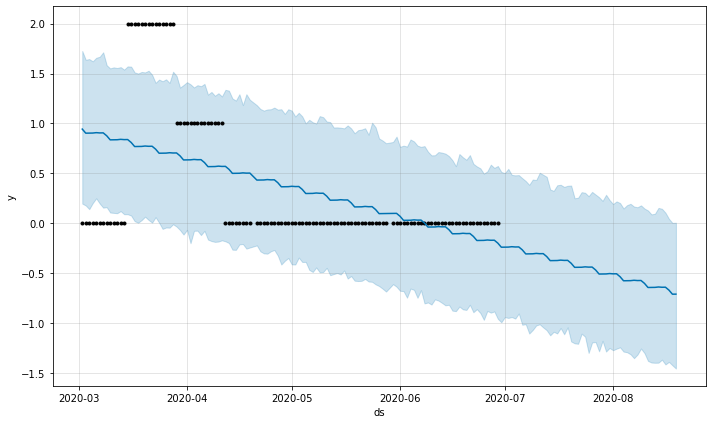

In [37]:
fig1 = prophet_model.plot(forecast)

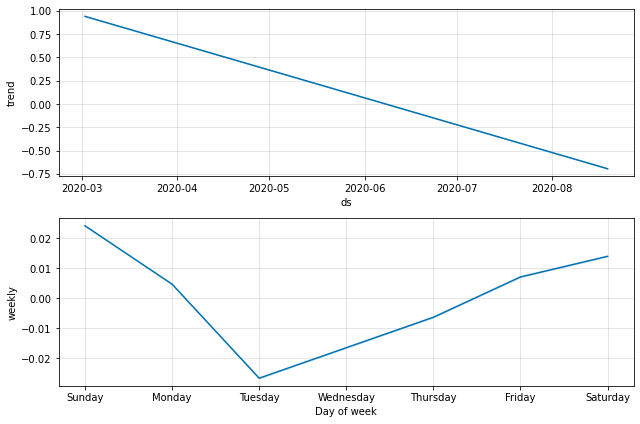

In [38]:
fig2 = prophet_model.plot_components(forecast)

In [39]:
plot_plotly(prophet_model, forecast)

In [40]:
plot_components_plotly(prophet_model, forecast)

### Diagnostics

In [41]:
# 172 total days of data (30%)
df_cv = cross_validation(prophet_model, initial='118 days', period='1 days', horizon = '1 days')
df_cv.tail()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-06-28 00:00:00 and 2020-06-28 00:00:00


ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2020-06-29 -0.206164   -0.969665    0.556807  0 2020-06-28

In [42]:
#cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])
#df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')

In [43]:
df_p = performance_metrics(df_cv)
df_p.head()

INFO:fbprophet:Skipping MAPE because y close to 0


horizon       mse      rmse       mae  mdape  coverage
0  1 days  0.042504  0.206164  0.206164    inf       1.0

INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Skipping MAPE because y close to 0


TypeError: ignored

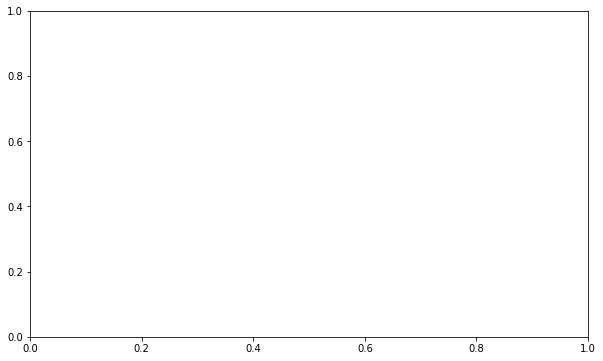

In [44]:
fig = plot_cross_validation_metric(df_cv, metric='mape')